In [1]:
import os
import cv2
import glob
from glob import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from IPython.display import display
from IPython.display import SVG, display

In [3]:
# !conda install opencv -y

In [2]:
#!conda install pandas=0.19.2 -y

In [4]:
import keras

Using TensorFlow backend.


In [5]:
basepath = '/home/dataset/train/'

all_cervix_images = []

for path in sorted(glob(basepath + "*")):
    #print(path)
    cervix_type = path.split("/")[-1]
    #print(cervix_type)
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    #print(cervix_images)
    all_cervix_images = all_cervix_images + cervix_images

all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,/home/dataset/train/Type_1/0.jpg,jpg,Type_1
1,/home/dataset/train/Type_1/10.jpg,jpg,Type_1
2,/home/dataset/train/Type_1/1013.jpg,jpg,Type_1
3,/home/dataset/train/Type_1/1014.jpg,jpg,Type_1
4,/home/dataset/train/Type_1/1019.jpg,jpg,Type_1


In [6]:
def im_multi(path):
    try:
        #print(path)
        im_stats_im_ = cv2.imread(path)
        #print(im_stats_im_.size)
        return [path, {'size': im_stats_im_.size}]
    except:
        print("Error path:%s"%(path))
        return [path, {'size': [0,0]}]
    
def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        #print(ret[i][0])
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join([str(s) for s in str(im_stats_d[x]['size'])]))
    return im_stats_df

def get_im_cv2(args):
    img = cv2.imread(args[0])
    resized = cv2.resize(img, (args[1], args[1]), cv2.INTER_LINEAR)
    return [args[0], resized]

def image_features(paths, dim):
    imf_d = {}
    p = Pool(cpu_count())
    dims = [dim for i in range(len(paths.tolist()))]
    params = list(zip(paths.tolist(), dims))
    ret = p.map(get_im_cv2, params)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    fdata = np.array(fdata, dtype = np.uint8)
    #fdata = fdata.transpose((0, 3, 1, 2)) # channels 放到前面
    #fdata = fdata.astype('float32') 
    #fdata = fdata / 255
    return fdata

In [10]:
import glob
train = glob.glob('/home/dataset/train/**/*.jpg')# + glob.glob('/data/kaggle/additional/**/*.jpg')
train =\
pd.DataFrame([[p.split('/')[4],p.split('/')[5],p] for p in train], columns = ['type','image','path'])#[:40]

In [17]:
train.head()

,type,image,path
0,Type_3,477.jpg,/home/dataset/train/Type_3/477.jpg
1,Type_3,1153.jpg,/home/dataset/train/Type_3/1153.jpg
2,Type_3,335.jpg,/home/dataset/train/Type_3/335.jpg
3,Type_3,324.jpg,/home/dataset/train/Type_3/324.jpg
4,Type_3,98.jpg,/home/dataset/train/Type_3/98.jpg


In [14]:
test = glob.glob('/home/dataset/test/*.jpg')
test = pd.DataFrame([[p.split('/')[4],p] for p in test], columns = ['image','path'])

In [55]:
test_id = test.image.values

In [16]:
test.head()

,image,path
0,477.jpg,/home/dataset/test/477.jpg
1,178.jpg,/home/dataset/test/178.jpg
2,335.jpg,/home/dataset/test/335.jpg
3,324.jpg,/home/dataset/test/324.jpg
4,98.jpg,/home/dataset/test/98.jpg


In [18]:
train_ = im_stats(train)
test_ = im_stats(test)

In [19]:
dim = 32
train_1 = train_[train_['size'] != '0 0'].reset_index(drop=True) #remove bad images
test_1 = test_[test_['size'] != '0 0'].reset_index(drop=True) #remove bad images

In [20]:
train_data = image_features(train_1['path'], dim)
test_data = image_features(test_1['path'], dim)

In [21]:
train_data.shape, test_data.shape

((1481, 32, 32, 3), (512, 32, 32, 3))

In [22]:
train_data = train_data[:,:,:,::-1]
test_data = test_data[:,:,:,::-1]

In [23]:
train_data.shape, test_data.shape

((1481, 32, 32, 3), (512, 32, 32, 3))

In [24]:
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)

In [25]:
np.unique(train_target),print(le.classes_)

['Type_1' 'Type_2' 'Type_3']


(array([0, 1, 2]), None)

In [26]:
dim = 32
def showX(X, dim):
    int_X = X
    int_X_reshape = int_X.reshape(-1,dim,dim,3).swapaxes(0,1).reshape(dim,-1,3)
    display(Image.fromarray(int_X_reshape))

In [27]:
image = train_data[:,:,:,:][0]

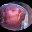

In [28]:
showX(image, dim) 

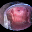

In [29]:
image_1 = image[:,::-1,:] # 左右鏡射
showX(image_1, dim)

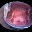

In [30]:
image_2 = image_1[::-1,:,:] # 上下鏡射
showX(image_2, dim)

In [31]:
def rotation(image, angle):
    assert image.shape[-1] == 3
    num_rows, num_cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), angle, 1)
    img_rotation = cv2.warpAffine(image, rotation_matrix, (num_cols, num_rows))
    return img_rotation

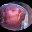

In [32]:
showX(image, dim) 

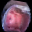

In [33]:
showX(rotation(image,80),dim)

In [34]:
train_data[1].shape

(32, 32, 3)

In [35]:
from collections import defaultdict

In [36]:
# rot_num = 4
# rot_imgs = defaultdict(list)
# for i in range(train_data.shape[0]):
#     #print(i)
#     #showX(train_data[i,:,:,:], dim)
#     for rot in range(int(360/rot_num),360,int(360/rot_num)):
#         #print(rot)
#         rot_img = rotation(train_data[i,:,:,:], rot)
#         rot_imgs[rot].append(rot_img)
#         #showX(rot_img, dim)
#     #break

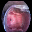

In [26]:
#showX(rot_imgs[90][0], dim)

https://www.packtpub.com/mapt/book/application_development/9781785283932/1/ch01lvl1sec12/image-rotation

In [37]:
#train_Y = np.concatenate([train_target for i in range(3)])
train_Y = np.concatenate([train_target for i in range(1)])

In [28]:
# train_data_ra1 = train_data[:,:,::-1,:] # 左右鏡射
# train_data_ra2 = train_data[:,::-1,:,:] # 上下鏡射

In [40]:
# train_X = np.concatenate([train_data, train_data_ra1, train_data_ra2])
train_X = np.concatenate([train_data])#, train_data_ra1, train_data_ra2])

In [42]:
train_X.shape, train_Y.shape

((1481, 32, 32, 3), (1481,))

In [43]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split

batch_size = 32
num_classes = 3
epochs = 10
data_augmentation = True

In [44]:
x_train, x_val_train, y_train, y_val_train =\
train_test_split(train_X, train_Y, test_size=0.2, random_state=17)

In [45]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val_train = keras.utils.to_categorical(y_val_train, num_classes)

In [47]:
#train_data = train_data.reshape(-1,3,32*32).shape

In [1]:
x_train.shape,x_val_train.shape,y_train.shape, y_val_train.shape

NameError: name 'x_train' is not defined

In [49]:
model = Sequential()
model.add(Reshape((32,32,3), input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), padding='same',data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))

model.add(Conv2D(64, (3, 3), padding='same',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [51]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [52]:
x_train = x_train.astype('float32')
x_val_train = x_val_train.astype('float32')

x_train /= 255
x_val_train /= 255

In [59]:
x_test = test_data.astype('float32')
x_test /= 255

In [54]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,              # set input mean to 0 over the dataset
        samplewise_center=False,               # set each sample mean to 0
        featurewise_std_normalization=False,   # divide inputs by std of the dataset
        samplewise_std_normalization=False,    # divide each input by its std
        zca_whitening=False,                   # apply ZCA whitening
        rotation_range = 180,                  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,                 # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                  # randomly flip images
        vertical_flip=False,
        data_format = "channels_last")         # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size = batch_size),
                        steps_per_epoch = x_train.shape[0],# // batch_size,
                        epochs=epochs,
                        validation_data=(x_val_train, y_val_train))

Using real-time data augmentation.
Epoch 1/10
1184/1184 [==============================] - 31s - loss: 0.9542 - acc: 0.5431 - val_loss: 0.9145 - val_acc: 0.5421

In [70]:
pred = model.predict_proba(x_test)

 32/512 [>.............................] - ETA: 0s

In [71]:
df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3'])

In [73]:
df['image_name'] = test_id

In [ ]:
df = df[['image_name','Type_1','Type_2','Type_3']]

In [74]:
df.to_csv('submission2.csv', index=False)